In [4]:
import pandas as pd
import os
dataset_path = "datasets/Choet_Dataset/MESOS_deep-se.csv"
df = pd.read_csv(os.path.expanduser(dataset_path))
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issuekey     1680 non-null   object
 1   title        1680 non-null   object
 2   description  1562 non-null   object
 3   storypoint   1680 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 52.6+ KB
None
    issuekey                                              title  \
0  MESOS-313  Report executor terminations to framework sche...   
1  MESOS-336                 Mesos slave should cache executors   
2  MESOS-343           Expose TASK_FAILED reason to Frameworks.   
3  MESOS-487    Balloon framework fails to run due to bad flags   
4  MESOS-598  Also check 'git diff --shortstat --staged' in ...   

                                         description  storypoint  
0  The Scheduler interface has a callback for exe...           2  
1  The slave should be smarter about how it handl...   

In [5]:
import re
import pandas as pd

def clean_text(text):
    """Cleans text by removing special characters and extra spaces."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()
df["description"] = df["description"].fillna("")  # Safe way to handle NaN values
df["text"] = df["title"] + " " + df["description"]
df["text"] = df["text"].apply(clean_text)
df = df[["text", "storypoint"]]

print(df.head())
df.to_csv("prepro.csv", index=False)


                                                text  storypoint
0  report executor terminations to framework sche...           2
1  mesos slave should cache executors the slave s...           5
2  expose task_failed reason to frameworks we now...           8
3  balloon framework fails to run due to bad flag...           1
4  also check git diff shortstat staged in postre...           1


In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    """Tokenizes and lemmatizes text using Spacy."""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])
df["text"] = df["text"].apply(lemmatize_text)
print(df.head())
df.to_csv("lemma.csv", index=False)

                                                text  storypoint
0  report executor termination framework schedule...           2
1  mesos slave cache executor slave smart handle ...           5
2  expose task_faile reason framework message str...           8
3  balloon framework fail run bad flag suspect la...           1
4  check git diff shortstat stage postreviewspy c...           1


In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import numpy as np
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
def get_bert_embeddings(text_list):
    """Converts text into BERT embeddings."""
    embeddings = []
    for text in tqdm(text_list, desc="Encoding Text"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())  # CLS token representation
    return np.array(embeddings)
X = get_bert_embeddings(df["text"].tolist())
y = df["storypoint"].values
df_embeddings = pd.DataFrame(X, columns=[f"dim_{i}" for i in range(X.shape[1])])  # 768 dimensions
df_embeddings["storypoint"] = y  # Append story point
df_embeddings.to_csv("bert_embeddings.csv", index=False)
np.save("X_bert_embeddings.npy", X)
np.save("y_storypoints.npy", y)
print("✅ BERT embeddings successfully generated and saved!")


Encoding Text: 100%|████████████████████████| 1680/1680 [01:18<00:00, 21.47it/s]


✅ BERT embeddings successfully generated and saved!


In [5]:
from sklearn.model_selection import train_test_split
X = np.load("X_bert_embeddings.npy")
y = np.load("y_storypoints.npy")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")


Training set: (1176, 768), Validation set: (168, 768), Testing set: (336, 768)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
class StoryPointEstimator(nn.Module):
    def __init__(self, input_dim=768):
        super(StoryPointEstimator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)  # Output: Story Points
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)  # Regression output

model = StoryPointEstimator()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ Model initialized!")


✅ Model initialized!


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ Data converted to PyTorch tensors & DataLoaders created!")


✅ Data converted to PyTorch tensors & DataLoaders created!


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch).item()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
print("✅ Model training complete!")


Epoch 1/10 | Train Loss: 7.0797 | Val Loss: 4.9338
Epoch 2/10 | Train Loss: 5.7029 | Val Loss: 4.5872
Epoch 3/10 | Train Loss: 5.6787 | Val Loss: 5.1942
Epoch 4/10 | Train Loss: 5.7696 | Val Loss: 4.7972
Epoch 5/10 | Train Loss: 5.0031 | Val Loss: 5.0178
Epoch 6/10 | Train Loss: 5.0007 | Val Loss: 4.2135
Epoch 7/10 | Train Loss: 4.8783 | Val Loss: 7.0522
Epoch 8/10 | Train Loss: 5.1134 | Val Loss: 4.5687
Epoch 9/10 | Train Loss: 4.3346 | Val Loss: 5.2206
Epoch 10/10 | Train Loss: 3.9933 | Val Loss: 4.6528
✅ Model training complete!


In [9]:
import pandas as pd
import torch
model.eval()
data_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch).cpu().numpy().flatten()
        
        for actual, predicted, text in zip(y_batch.numpy().flatten(), predictions, X_test):
            data_list.append([actual, round(predicted, 2), text])
df_results = pd.DataFrame(data_list, columns=["Actual Story Point", "Predicted Story Point", "Text Description"])
pd.set_option("display.max_colwidth", 100)  # Ensure text is visible
print(df_results.head(10))  # Show first 10 predictions


   Actual Story Point  Predicted Story Point  \
0                 1.0                   1.54   
1                 3.0                   2.50   
2                 2.0                   2.48   
3                 1.0                   1.37   
4                 5.0                   2.62   
5                 1.0                   1.69   
6                 3.0                   1.63   
7                 3.0                   2.42   
8                 3.0                   3.52   
9                 5.0                   1.35   

                                                                                      Text Description  
0  [-0.51307815, 0.053869396, 0.028921638, -0.0021292444, -0.14894006, -0.22556835, 0.43945062, -0....  
1  [-0.07826933, -0.31877875, -0.18824898, 0.12675956, 0.019341938, -0.23900057, 0.45525256, 0.3388...  
2  [-0.5393267, 0.071635455, 0.11788444, -0.21940534, 0.026842164, 0.004425547, 0.3905327, -0.00627...  
3  [-0.36870787, 0.13558611, 0.110777, -0.079841994

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model.eval()
# Store true vs. predicted values
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch).cpu().numpy().flatten()

        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(predictions)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"✅ Model Evaluation Metrics:\nMAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")


✅ Model Evaluation Metrics:
MAE: 1.4783 | RMSE: 2.3279 | R²: -0.0150


In [13]:
torch.save(model.state_dict(), "story_point_model.pth")
print("✅ Model saved as story_point_model.pth!")


✅ Model saved as story_point_model.pth!


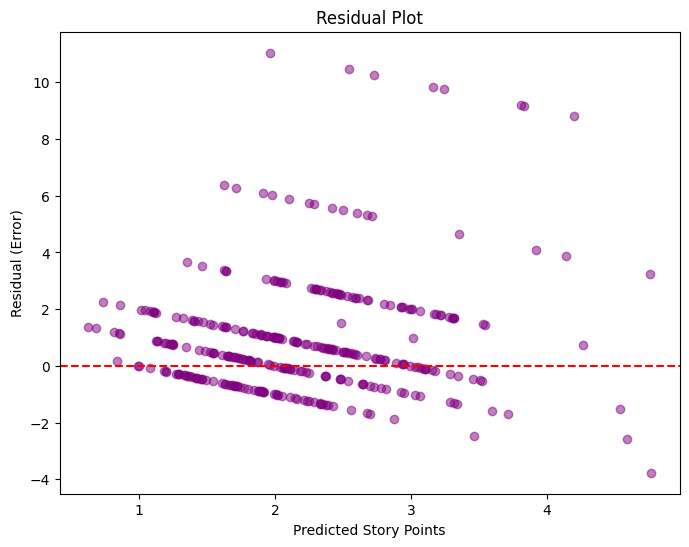

In [14]:
residuals = y_true - y_pred  #residuals

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Story Points")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot")
plt.show()


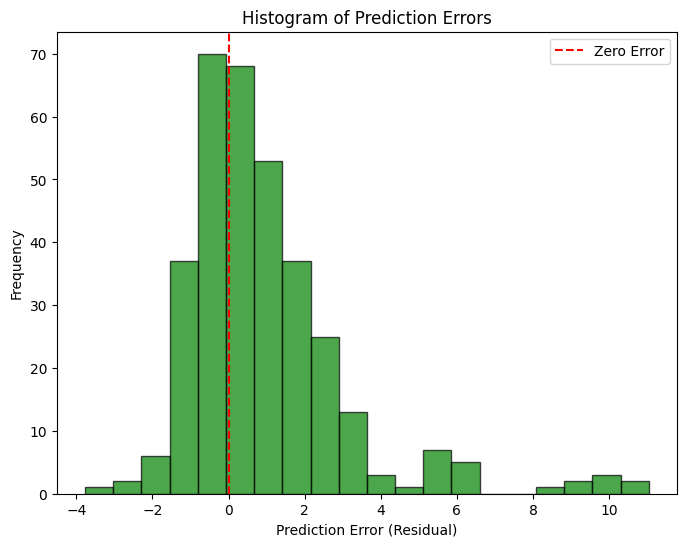

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color="green", edgecolor="black", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", label="Zero Error")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.legend()
plt.show()
